In [1]:
import os
import sys

sys.path.append("../../../")

import json
import pickle

import fasttreeshap
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import RepeatedKFold, cross_val_score

%reload_ext autoreload
%autoreload 2

/home/danna/unicef-ai4d-poverty-mapping/env/lib/python3.9/site-packages/fasttreeshap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/danna/unicef-ai4d-poverty-mapping/env/lib/python3.9/site-packages/fasttreeshap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-ji

# Load Training Data

In [2]:
COUNTRY_CODE = "ph"
ROLLOUT_DATE = "-".join(os.getcwd().split("/")[-2].split("-")[:3])

# CSV file contains all data
# Metadata JSON file lists the feature columns and label column
data = pd.read_csv(f"{ROLLOUT_DATE}-training-data.csv")
with open(f"{ROLLOUT_DATE}-training-data-columns.json", "r") as file:
    column_metadata = json.load(file)

features = data[column_metadata["features"]]
labels = data[column_metadata["label"]]

# Cross-Validation

In [3]:
# Set parameters
CV_K_FOLDS = 5
CV_NUM_REPEATS = 5
RANDOM_SEED = 42

In [4]:
print(f"Performing {CV_K_FOLDS}-fold CV...")
cv = RepeatedKFold(
    n_splits=CV_K_FOLDS,
    n_repeats=CV_NUM_REPEATS,
    random_state=RANDOM_SEED,
)

print(cv.split(features))

Performing 5-fold CV...
<generator object _RepeatedSplits.split at 0x7f0d0fe21580>


In [5]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED, verbose=0)

R_cv = cross_val_score(model, features.values, labels.values.ravel(), cv=cv)
cv_mean = round(np.array(R_cv).mean(), 2)
cv_std = round(np.array(R_cv).std(), 2)

print("Cross validation scores are: ", R_cv)
print(f"Cross validation R^2 mean: {cv_mean}")
print(f"Cross validation R^2 std: {cv_std}")

Cross validation scores are:  [0.55456895 0.62920139 0.59238305 0.6138791  0.5882295  0.58336661
 0.61811663 0.55827213 0.56957906 0.63258748 0.64900895 0.61705625
 0.60101912 0.54786873 0.54310961 0.53706267 0.59540953 0.62964757
 0.55945858 0.60114516 0.58737818 0.53893298 0.62444129 0.63935489
 0.59631923]
Cross validation R^2 mean: 0.59
Cross validation R^2 std: 0.03


# Train the final model

For training the final model, we train on all the available data.

In [6]:
model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED, verbose=0)
model.fit(features.values, labels.values.ravel())

RandomForestRegressor(random_state=42)

In [7]:
model_save_path = f"./{ROLLOUT_DATE}-{COUNTRY_CODE}-single-country-model.pkl"
with open(model_save_path, "wb") as file:
    pickle.dump(model, file)

# SHAP

In [8]:
explainer = fasttreeshap.TreeExplainer(model, algorithm="auto", n_jobs=-1)
shap_values = explainer(features).values

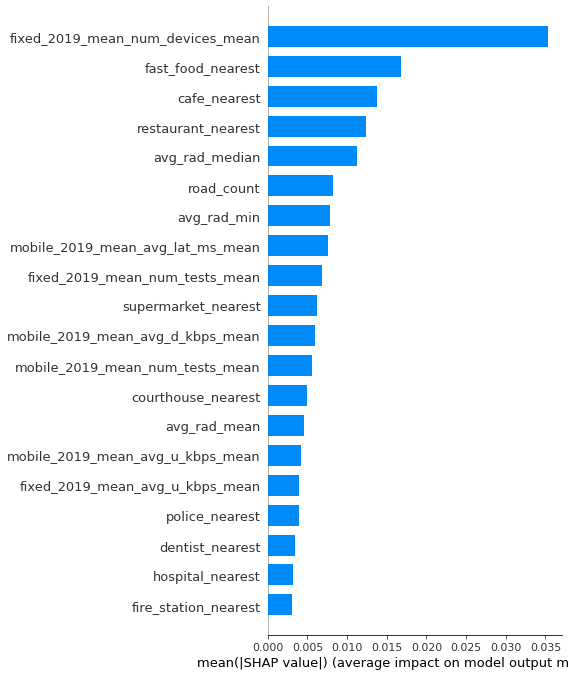

In [9]:
shap.summary_plot(
    shap_values, features, feature_names=features.columns, plot_type="bar"
)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


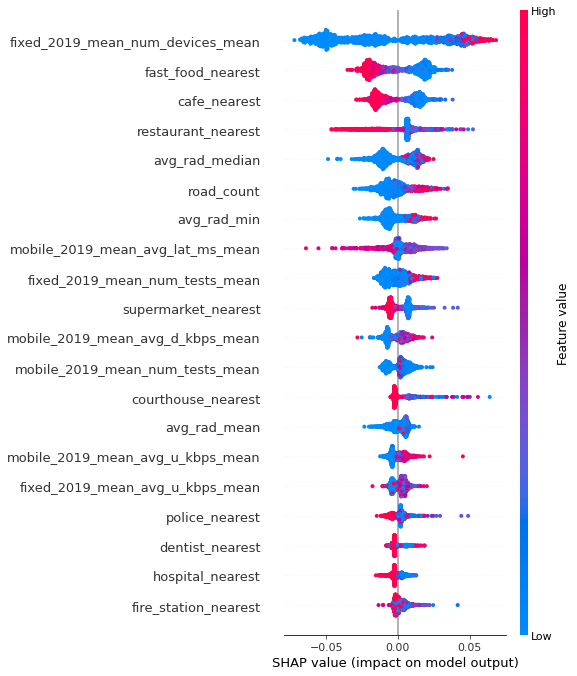

In [10]:
shap.summary_plot(shap_values, features.values, feature_names=features.columns)